In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image

1.1 数据加载

In [2]:
def data_load(data_dir,patch_size):
  data1 = []
  data2 = []
  paths,dirs,file_name = next(os.walk(data_dir))
  for dir in dirs:
    if dir == 'images':
      file_paths = os.path.join(paths,dir)
      for fname in os.listdir(file_paths):
        image = cv2.imread(os.path.join(file_paths,fname),1)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        size_x = (image.shape[1] // patch_size) * patch_size
        size_y = (image.shape[0] // patch_size) * patch_size
        image = Image.fromarray(image)
        image = image.crop((0,0,size_x,size_y))
        image = np.array(image)
        data1.append(image)
    elif dir == 'masks':
      file_paths = os.path.join(paths,dir)
      for fname in os.listdir(file_paths):
        image = cv2.imread(os.path.join(file_paths,fname),0)
        size_x = (image.shape[1] // patch_size) * patch_size
        size_y = (image.shape[0] // patch_size) * patch_size
        image = Image.fromarray(image)
        image = image.crop((0,0,size_x,size_y))
        image = np.array(image)
        data2.append(image)
  return data1,data2

In [3]:
data_dir = "module1/data/"
patch_size = 256
images,masks = data_load(data_dir,patch_size)

In [4]:
np.unique(masks[0])

array([0, 1, 2, 3, 4], dtype=uint8)

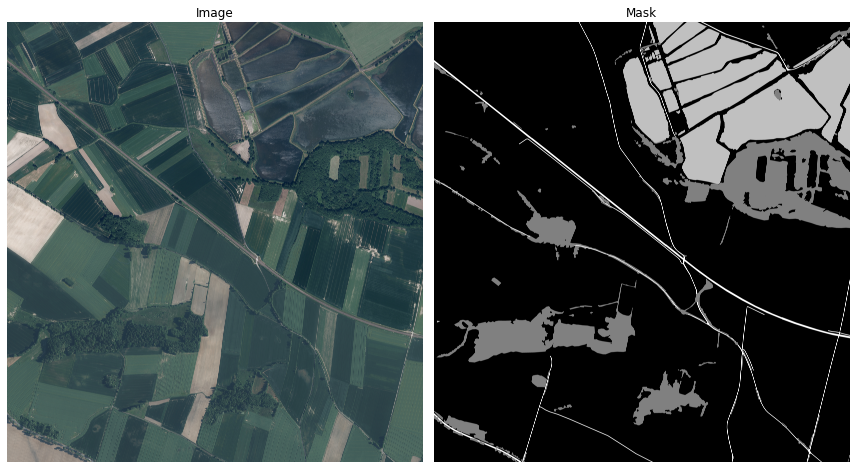

In [5]:
flg,axes = plt.subplots(1,2,figsize=(12,8))
axes[0].set_title("Image")
axes[0].imshow(images[0])
axes[0].axis("off")
axes[1].set_title("Mask")
axes[1].imshow(masks[0],cmap='gray')
axes[1].axis("off")
plt.tight_layout()
plt.show()

1.2 去除图像logo

In [6]:
def remove_logo(images):
  data = []
  for image in images:
    w = image.shape[1]
    h = image.shape[0]

    x1 = w - 1000
    y1 = h - 1000
    x2 = w
    y2 = h
    logo_mask = np.zeros(image.shape[:2],np.uint8)
    cv2.rectangle(logo_mask,(x1,y1),(x2,y2),255,-1)
    inpainted_mask = cv2.inpaint(image,logo_mask,4,cv2.INPAINT_TELEA)
    data.append(inpainted_mask)
  return data

In [7]:
remove_images = remove_logo(images)

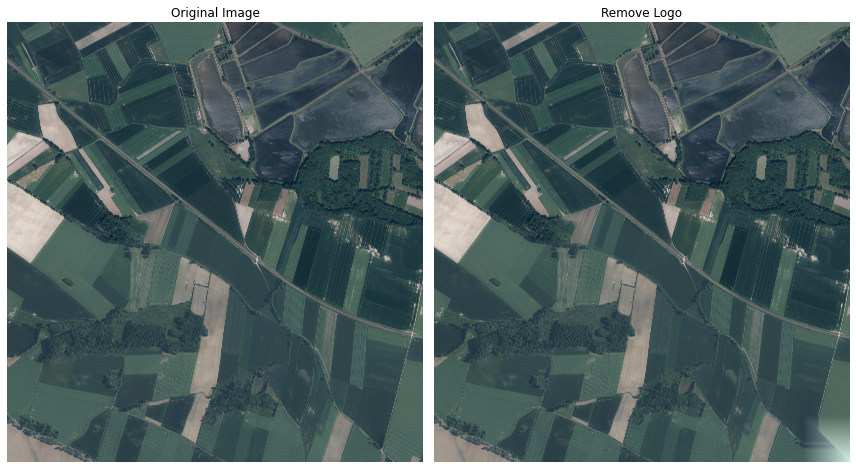

In [8]:
flg,axes = plt.subplots(1,2,figsize=(12,8))
axes[0].set_title("Original Image")
axes[0].imshow(images[0])
axes[0].axis("off")
axes[1].set_title("Remove Logo")
axes[1].imshow(remove_images[0])
axes[1].axis("off")
plt.tight_layout()
plt.show()

1.3 图像均衡化

In [9]:
def spilit_channel_image(images):
  data = []
  for image in images:
    R,G,B = cv2.split(image)
    channel_R = cv2.equalizeHist(R)
    channel_G = cv2.equalizeHist(G)
    channel_B = cv2.equalizeHist(B)
    image = cv2.merge([channel_R,channel_G,channel_B])
    data.append(image)
  return data

In [10]:
hist_images = spilit_channel_image(remove_images)

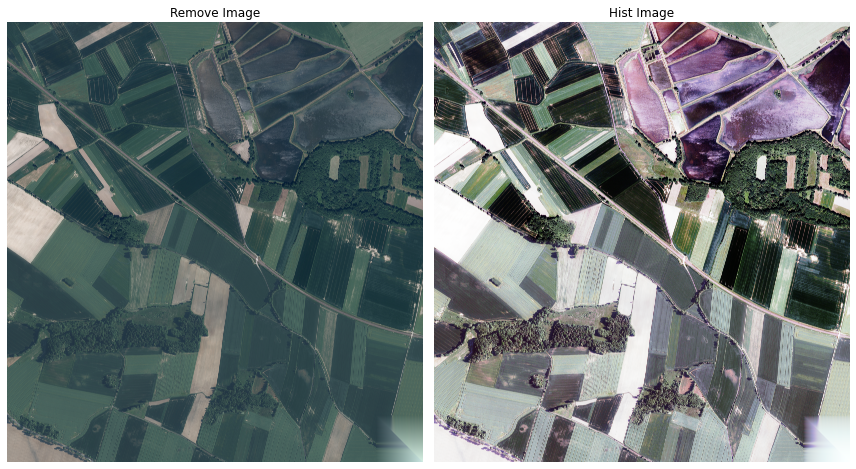

In [11]:
flg,axes = plt.subplots(1,2,figsize=(12,8))
axes[0].set_title("Remove Image")
axes[0].imshow(remove_images[0])
axes[0].axis("off")
axes[1].set_title("Hist Image")
axes[1].imshow(hist_images[0])
axes[1].axis("off")
plt.tight_layout()
plt.show()

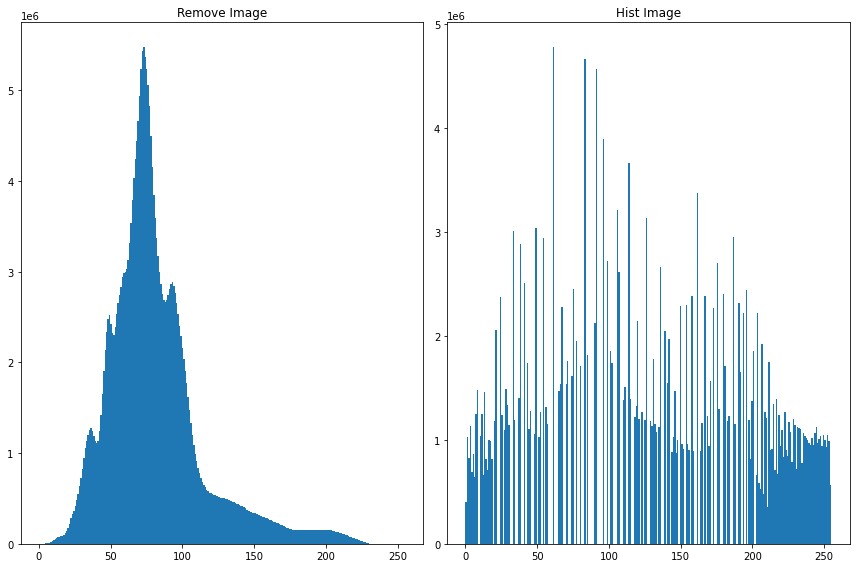

In [12]:
flg,axes = plt.subplots(1,2,figsize=(12,8))
axes[0].set_title("Remove Image")
axes[0].hist(remove_images[0].ravel(),256)
axes[1].set_title("Hist Image")
axes[1].hist(hist_images[0].ravel(),256)
plt.tight_layout()
plt.show()

1.4 双边滤波

In [13]:
def bilateral_images(images):
  data = []
  for image in images:
    image = cv2.bilateralFilter(image,20,40,40)
    data.append(image)
  return data

In [14]:
filter_images = bilateral_images(hist_images)

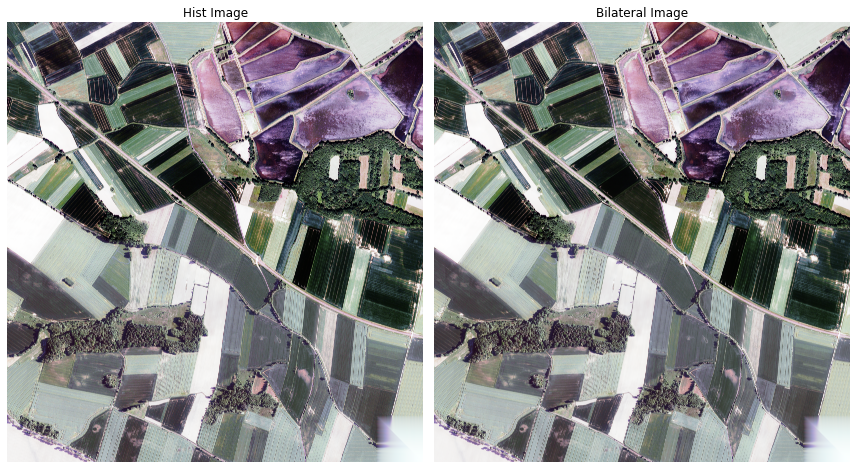

In [15]:
flg,axes = plt.subplots(1,2,figsize=(12,8))
axes[0].set_title("Hist Image")
axes[0].imshow(hist_images[0])
axes[0].axis("off")
axes[1].set_title("Bilateral Image")
axes[1].imshow(filter_images[0])
axes[1].axis("off")
plt.tight_layout()
plt.show()

2.1 图像切割

In [16]:
from patchify import patchify
from sklearn.preprocessing import MinMaxScaler,StandardScaler
scaler = MinMaxScaler()

In [17]:
def add_images(images,patch_size):
  data = []
  for image in images:
    patched_image = patchify(image,(patch_size,patch_size,3),step=patch_size)
    for i in range(patched_image.shape[0]):
      for j in range(patched_image.shape[1]):
        single = patched_image[i,j,:,:]
        single = scaler.fit_transform(single.reshape(-1,single.shape[-1])).reshape(single.shape)
        single = single[0]
        data.append(single)
  return data

In [18]:
def add_masks(images,patch_size):
  data = []
  for image in images:
    patched_image = patchify(image,(patch_size,patch_size),step=patch_size)
    for i in range(patched_image.shape[0]):
      for j in range(patched_image.shape[1]):
        single = patched_image[i,j,:,:]
        # single = scaler.fit_transform(single.reshape(-1,single.shape[-1])).reshape(single.shape)
        # single = single[0]
        data.append(single)
  return data

In [19]:
masks[0].shape

(9472, 8960)

In [20]:
image_data = add_images(filter_images,patch_size)
mask_data = add_masks(masks,patch_size)

In [21]:
np.unique(mask_data)

array([0, 1, 2, 3, 4], dtype=uint8)

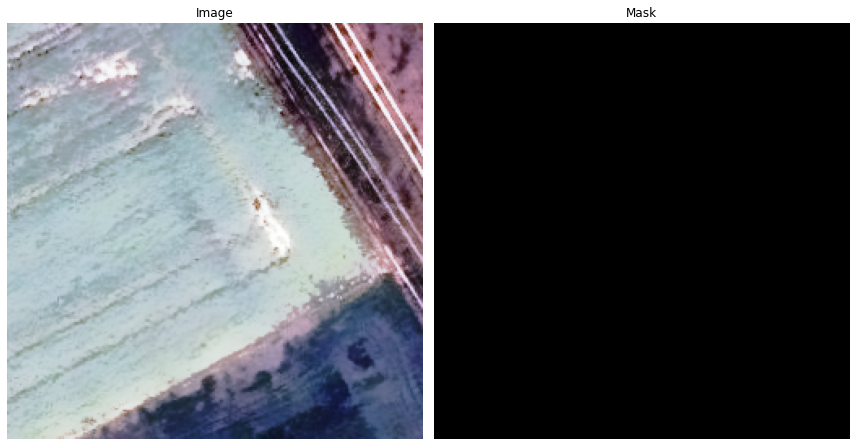

In [22]:
flg,axes = plt.subplots(1,2,figsize=(12,8))
axes[0].set_title("Image")
axes[0].imshow(image_data[3])
axes[0].axis("off")
axes[1].set_title("Mask")
axes[1].imshow(mask_data[3],cmap='gray')
axes[1].axis("off")
plt.tight_layout()
plt.show()

2.2 去除无意义图像

In [23]:
def move_image(images,masks):
  useless = 0
  data1 = []
  data2 = []
  for image,mask in zip(images,masks):
    val,counts = np.unique(mask,return_counts=True)
    if (1-(counts[0] / counts.sum())) > 0.05:
      data1.append(image)
      data2.append(mask)
    else:
      useless += 1
  return data1,data2
  print(f"移除掉{useless}张图片")

In [24]:
images_dataset,masks_dataset = move_image(image_data,mask_data)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


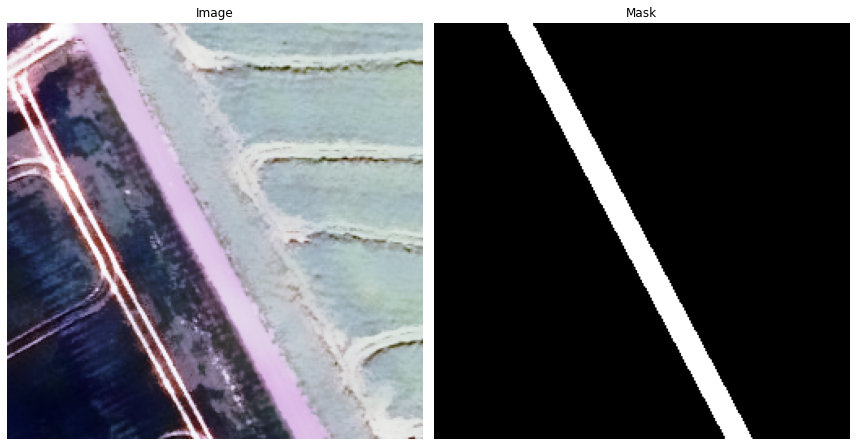

In [25]:
flg,axes = plt.subplots(1,2,figsize=(12,8))
axes[0].set_title("Image")
axes[0].imshow(images_dataset[0])
axes[0].axis("off")
axes[1].set_title("Mask")
axes[1].imshow(masks_dataset[0],cmap='gray')
axes[1].axis("off")
plt.tight_layout()
plt.show()

2.3 图像增强

In [26]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [27]:
datagen = ImageDataGenerator(
    horizontal_flip=True
)

In [28]:
def data_gen(images,masks,num_batch_size):
  data1 = []
  data2 = []
  for image,mask in zip(images,masks):
    image_array = image / 255.0
    image_array = np.expand_dims(image_array,axis=0)
    generator1 = datagen.flow(image_array,seed=0,batch_size=1)

    mask_array = mask / 255.0
    mask_array = np.expand_dims(mask_array,axis=0)
    mask_array = np.expand_dims(mask_array,axis=-1)
    generator2 = datagen.flow(mask_array,seed=0,batch_size=1)

    for batch_index in range(num_batch_size):
      image1 = generator1.next()[0]
      data1.append(image1)
      mask1 = generator2.next()[0]
      maks1 = mask1[:,:,0]
      data2.append(mask1)
  return data1,data2

In [29]:
# import tensorflow as tf
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [30]:
# def numpy_to_pil(images):
#   pil_images = [Image.fromarray((image * 255).astype(np.uint8)) for image in images]
#   return pil_images

In [31]:
# pil_images = numpy_to_pil(images_dataset)
# pil_masks = numpy_to_pil(masks_dataset)

In [32]:
# flg,axes = plt.subplots(1,2,figsize=(12,8))
# axes[0].set_title("Image")
# axes[0].imshow(pil_images[0])
# axes[0].axis("off")
# axes[1].set_title("Mask")
# axes[1].imshow(pil_masks[0])
# axes[1].axis("off")
# plt.tight_layout()
# plt.show()

In [33]:
# datagen = ImageDataGenerator(
#         horizontal_flip=True
#     )
# num_batches_to_save=3

In [34]:
# def data_gen(images,masks):
#   data1 = []
#   data2 = []
#   for image,masks in zip(images,masks):
#     image_array = np.array(image) / 255.0
#     image_array = np.expand_dims(image_array, axis=0)
#     generator1 = datagen.flow(image_array,seed = 0, batch_size=1)

#     mask_array = np.array(masks) / 255.0
#     mask_array = np.expand_dims(mask_array, axis=0)
#     mask_array = np.expand_dims(mask_array, axis=-1)
#     generator2 = datagen.flow(mask_array,seed = 0, batch_size=1)

#     for batch_index in range(num_batches_to_save):
#         augmented_image1 = generator1.next()[0]
#         # augmented_pil_image1 = Image.fromarray((augmented_image1 * 255).astype(np.uint8))
#         # augmented_pil_image1 = np.array(augmented_pil_image1)
#         # data1.append(augmented_pil_image1)
#         data1.append(augmented_image1)

#         augmented_image2 = generator2.next()[0]
#         augmented_image2 = augmented_image2[:, :, 0]  # 取出第一通道
#         # augmented_pil_image2 = Image.fromarray((augmented_image2 * 255).astype(np.uint8))
#         # augmented_pil_image2 = np.array(augmented_pil_image2)
#         # data2.append(augmented_pil_image2)
#         data2.append(augmented_image2)
#   return data1,data2

In [35]:
# data1,data2 = data_gen(pil_images,pil_masks)

In [36]:
# display(len(pil_images),len(pil_masks))

In [37]:
num_batch_size=3
data1,data2 = data_gen(images_dataset,masks_dataset,num_batch_size)

In [38]:
display(len(images_dataset),len(masks_dataset))

4054

4054

In [39]:
display(len(data1),len(data2))

12162

12162

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


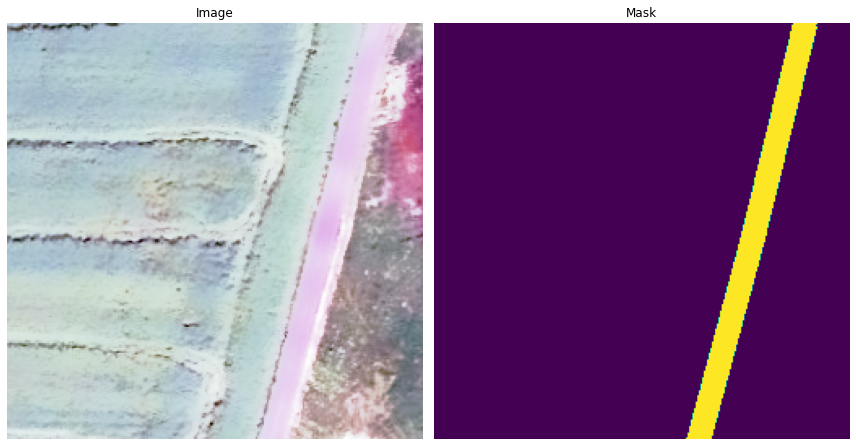

In [40]:
flg,axes = plt.subplots(1,2,figsize=(12,8))
axes[0].set_title("Image")
axes[0].imshow(images_dataset[1])
axes[0].axis("off")
axes[1].set_title("Mask")
axes[1].imshow(masks_dataset[1])
axes[1].axis("off")
plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


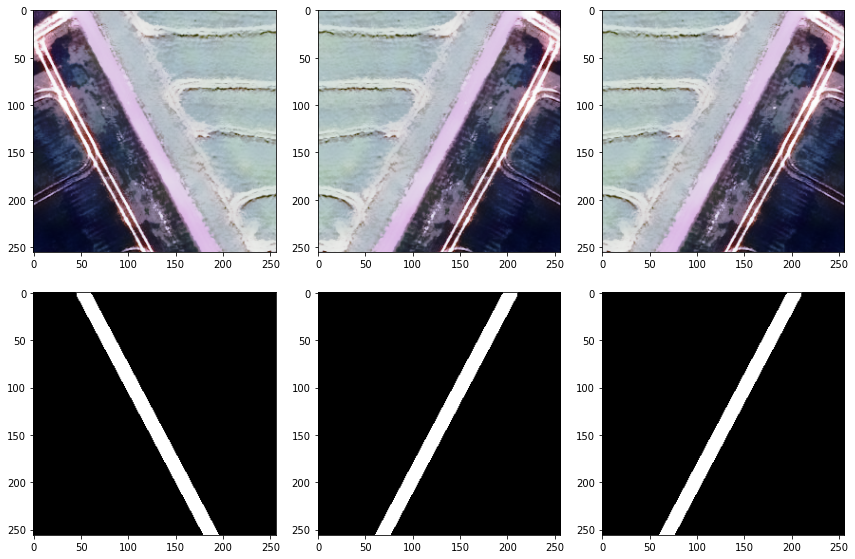

In [41]:
flg,axes = plt.subplots(2,3,figsize=(12,8))
axes[0,0].imshow(images_dataset[0])
axes[0,1].imshow(data1[1] * 255)
axes[0,2].imshow(data1[2] * 255)
axes[1,0].imshow(masks_dataset[0],cmap='gray')
axes[1,1].imshow(data2[1],cmap='gray')
axes[1,2].imshow(data2[2],cmap='gray')
plt.tight_layout()
plt.show()

2.4 肘部法则

In [42]:
import random
from sklearn.cluster import KMeans

In [43]:
inertia = []
k_values = range(1,11)

num = random.randint(0,len(data1))
pixels = data1[num].reshape(-1,data1[num].shape[-1])

for k in k_values:
  kmeans = KMeans(n_clusters=k,random_state=0)
  kmeans.fit(pixels)
  inertia.append(kmeans.inertia_)

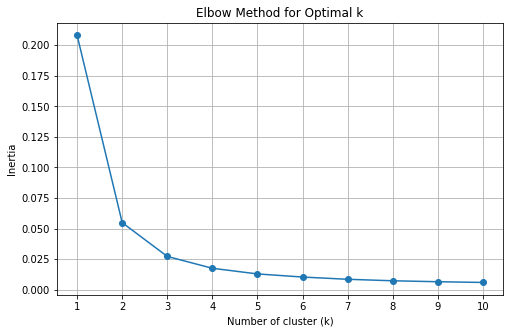

In [44]:
plt.figure(figsize=(8,5))
plt.plot(k_values,inertia,marker='o')
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of cluster (k)")
plt.ylabel("Inertia")
plt.xticks(k_values)
plt.grid()
plt.show()

2.5 构建聚类模型

In [45]:
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters,random_state=0)
kmeans

KMeans(n_clusters=3, random_state=0)

In [46]:
def kmeans_clustering(kmeans,images):
  kmeans_result = []
  for i,image in enumerate(images):
    pixels = image.reshape(-1,image.shape[-1])
    kmeans_labels = kmeans.fit_predict(pixels)
    kmeans_labels = kmeans_labels.reshape(image.shape[0],image.shape[1])
    kmeans_result.append(kmeans_labels)
    print(f"图像{i}处理完成")
  return kmeans_result

In [47]:
kmeans_result = kmeans_clustering(kmeans,data1[:10])

图像0处理完成
图像1处理完成
图像2处理完成
图像3处理完成
图像4处理完成
图像5处理完成
图像6处理完成
图像7处理完成
图像8处理完成
图像9处理完成


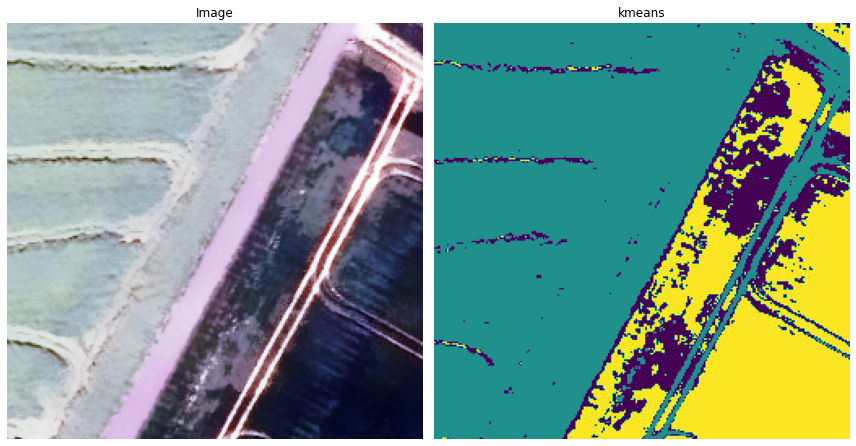

In [48]:
flg,axes = plt.subplots(1,2,figsize=(12,8))
axes[0].set_title("Image")
axes[0].imshow(data1[1] * 255)
axes[0].axis("off")
axes[1].set_title("kmeans")
axes[1].imshow(kmeans_result[1])
axes[1].axis("off")
plt.tight_layout()
plt.show()

3.1 图像处理



In [49]:
image_dataset = np.asarray(data1)
masks_dataset = np.asarray(data2)

In [50]:
image_dataset = image_dataset[:1000].astype('float64')
masks_dataset = image_dataset[:1000].astype('float64')

In [51]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(image_dataset,masks_dataset,test_size=0.2,random_state=0)

In [52]:
X_train.shape

(800, 256, 256, 3)

In [53]:
X_test.shape

(200, 256, 256, 3)

In [54]:
# X_train = image_dataset[:1000].astype('float64')
# X_test = image_dataset[:1000].astype('float64')

In [55]:
import segmentation_models as sm

Segmentation Models: using `keras` framework.


In [56]:
BACKBONE='resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

In [57]:
IMG_HEIGHT = image_dataset.shape[1]
IMG_WIDTH = image_dataset.shape[2]
IMG_CHANNELS = image_dataset.shape[3]

In [58]:
# n_classes=5
# model1 = sm.Unet(BACKBONE,
#                  encoder_weights='imagenet',
#                 input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
#                 classes=n_classes,
#                  activation='softmax')
# model1.compile('Adam', loss=sm.losses.categorical_focal_jaccard_loss, metrics=[sm.metrics.iou_score])

In [59]:
# history1 = model1.fit(X_train,y_test,batch_size=10,epochs=80)

In [60]:
# loss, iou_score = model1.evaluate(X_test, y_test, verbose=1)
# print(f"Average LOSS: {loss:.4f}")
# print(f"Average IOU: {iou_score:.4f}")

In [61]:
# # 保存模型
# model1.save('history1.hdf5')

In [62]:
from keras import Input
from keras import layers,Model

inputs = Input(shape=(256,256,3))
conv1 = layers.Conv2D(filters=32,kernel_size=3,activation='relu',padding='same')(inputs)
conv1 = layers.Conv2D(filters=32,kernel_size=3,activation='relu',padding='same')(conv1)

pool1 = layers.MaxPooling2D(pool_size=2)(conv1)
conv2 = layers.Conv2D(filters=64,kernel_size=3,activation='relu',padding='same')(pool1)
conv2 = layers.Conv2D(filters=64,kernel_size=3,activation='relu',padding='same')(conv2)

pool2 = layers.MaxPooling2D(pool_size=2)(conv2)
conv3 = layers.Conv2D(filters=128,kernel_size=3,activation='relu',padding='same')(pool2)
conv3 = layers.Conv2D(filters=128,kernel_size=3,activation='relu',padding='same')(conv3)

up1 = layers.UpSampling2D(size=(2,2))(conv3)
merge1 = layers.concatenate([conv2, up1],axis=3)
conv4 = layers.Conv2D(filters=64,kernel_size=3,activation='relu',padding='same')(merge1)
conv4 = layers.Conv2D(filters=64,kernel_size=3,activation='relu',padding='same')(conv4)

up2 = layers.UpSampling2D(size=(2,2))(conv4)
merge2 = layers.concatenate([conv1, up2],axis=3)
conv5 = layers.Conv2D(filters=32,kernel_size=3,activation='relu',padding='same')(merge2)
conv5 = layers.Conv2D(filters=32,kernel_size=3,activation='relu',padding='same')(conv5)

conv6 = layers.Conv2D(filters=3,kernel_size=3,activation='softmax',padding='same')(conv5)

model2 = Model(inputs=inputs, outputs=conv6)

In [63]:
# model.compile(optimizer='adam',loss='categorical_crossentropy',metrics='accuracy')
model2.compile(optimizer='adam',loss=sm.losses.categorical_focal_jaccard_loss,metrics=[sm.metrics.iou_score])

In [64]:
history2 = model2.fit(X_train,y_train,batch_size=10,epochs=80)

Epoch 1/80
80/80 [==============================] - 16s 99ms/step - loss: 0.9983 - iou_score: 0.0019
Epoch 2/80
80/80 [==============================] - 8s 99ms/step - loss: 0.9983 - iou_score: 0.0019
Epoch 3/80
80/80 [==============================] - 8s 100ms/step - loss: 0.9983 - iou_score: 0.0019
Epoch 4/80
80/80 [==============================] - 8s 100ms/step - loss: 0.9983 - iou_score: 0.0019
Epoch 5/80
80/80 [==============================] - 8s 100ms/step - loss: 0.9983 - iou_score: 0.0019
Epoch 6/80
80/80 [==============================] - 8s 100ms/step - loss: 0.9983 - iou_score: 0.0019
Epoch 7/80
80/80 [==============================] - 8s 100ms/step - loss: 0.9983 - iou_score: 0.0019
Epoch 8/80
80/80 [==============================] - 8s 100ms/step - loss: 0.9983 - iou_score: 0.0019
Epoch 9/80
80/80 [==============================] - 8s 100ms/step - loss: 0.9983 - iou_score: 0.0019
Epoch 10/80
80/80 [==============================] - 8s 100ms/step - loss: 0.9983 - iou_scor

In [65]:
loss, iou_score = model2.evaluate(X_test, y_test, verbose=1)
print(f"Average LOSS: {loss:.4f}")
print(f"Average IOU: {iou_score:.4f}")

7/7 [==============================] - 3s 168ms/step - loss: 0.9979 - iou_score: 0.0026
Average LOSS: 0.9979
Average IOU: 0.0026


In [66]:
# 保存模型
model2.save('history2.hdf5')

In [67]:
predictions = model2.predict(X_test, batch_size=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


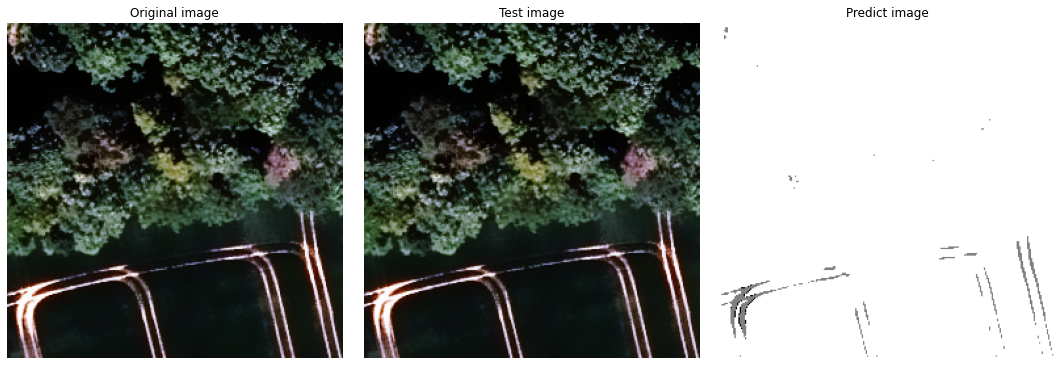

In [69]:
# 展示第一张图片
fig,axs = plt.subplots(1,3,figsize=(15,5))
axs[0].imshow(X_test[1] * 255)
axs[0].set_title("Original image")
axs[0].axis('off')
axs[1].imshow(y_test[1] * 255,cmap='gray')
axs[1].set_title("Test image")
axs[1].axis('off')
axs[2].imshow(np.argmax(predictions[1],axis=-1),cmap='gray')
axs[2].set_title("Predict image")
axs[2].axis('off')
plt.tight_layout()
plt.show()